<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#pip install en_core_web_sm -q
#%matplotlib inline
#!pip install --upgrade Pillow==9.5.0
#!pip install wordcloud==1.8.0
#!pip install shap

In [2]:
import re
import nltk
import os
import shap
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

Скачиваем необходимые словари:

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
#nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
pth_0 = r'C:\Users\Grigory\Downloads\toxic_comments.csv'
pth_1 = '/datasets/toxic_comments.csv'

if os.path.exists(pth_0):
    df = pd.read_csv(pth_0)
    print('from disk')
elif os.path.exists(pth_1):
    df = pd.read_csv(pth_1)
    print('from server')
else: 
    print('something is wrong')

from server


In [5]:
display(df)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
stop_words = set(stopwords.words('english'))

In [8]:
def clean_text(text):
    text = text.lower()                                            #нижний регистр
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)            #удалить ссылки
    text = re.sub(r"@\w+", '', text)                               #удалить обращения через @
    text = re.sub(r"[^\w\s]", '', text)                            #удалить пунктуацию
    text = re.sub(r"\d+", '', text)                                #удалить числа
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

In [9]:
tqdm.pandas()

Очищаем текст:

In [10]:
df['clean'] = df['text'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

Считаем количество слов:

In [11]:
df['count_words'] = df['clean'].apply(lambda x: len(x.split()))

Смотрим где слов 0

In [12]:
display(df.loc[df['count_words'] == 0])

,Unnamed: 0,text,toxic,clean,count_words
2400,2400,"Here, here and here.",0,,0
3983,3983,From here\n\nFrom here 160.80.2.8,0,,0
4475,4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,,0
6182,6186,http://www.imdb.com/name/nm2551199/filmoseries...,0,,0
6289,6293,193.61.111.53 15:00,0,,0
...,...,...,...,...,...
148595,148751,she did 76.122.79.82,0,,0
151107,151263,10 - 2010 04 08 to 2010 05 12,0,,0
152543,152700,SAME FOR THIS 166.137.240.20,0,,0
153041,153198,which is OVER 9000 OVER 9000 OVER 9000 OVER 90...,0,,0


In [13]:
df = df.loc[df['count_words'] != 0]
df = df.reset_index(drop=True)

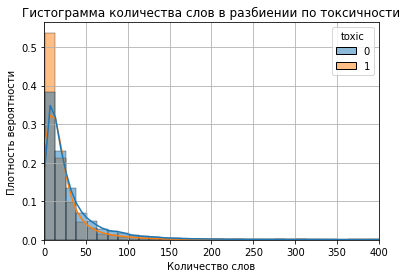

In [14]:
sns.histplot(data=df, x='count_words', hue='toxic', bins=100, kde=True, stat='probability', common_norm=False)
plt.title('Гистограмма количества слов в разбиении по токсичности')
plt.xlim([0,400])
plt.xlabel('Количество слов')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

Большинство отзывов имеют меньше 50 слов. Токсичные отзывы наиболее короткие. Длинные отзывы в основном нетоксичные.

In [15]:
df['mean'] = df['clean'].apply(lambda x: sum(len(word) for word in x.split())/len(x.split()))

In [16]:
def Sent(text):
    return sia.polarity_scores(text)

In [17]:
sia = SentimentIntensityAnalyzer()

sia_df = df['clean'].progress_apply(lambda x: sia.polarity_scores(x)).to_list()


  0%|          | 0/159222 [00:00<?, ?it/s]

In [18]:
sia_df = pd.DataFrame(sia_df)
df = pd.concat([df, sia_df], axis = 1)

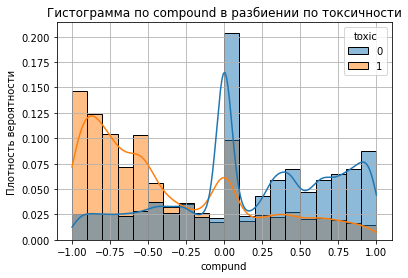

In [19]:
sns.histplot(data=df, x='compound', hue='toxic', bins=20, kde=True, stat='probability', common_norm=False)
plt.title('Гистограмма по compound в разбиении по токсичности')
#plt.xlim([0,400])
plt.xlabel('compund')
plt.ylabel('Плотность вероятности')
plt.grid(True)
plt.show()

*SentimentIntensityAnalyzer* справился неидеально.

In [20]:
counts = df['toxic'].value_counts()
ratio = counts[0] / counts[1]
print(ratio)

8.837627432808155


Пропусков нет, лишний столбец потом удалим.

Функции для лемматизации и очищения текста:

In [21]:
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_space])

def lemmatize(text):
    tokens = word_tokenize(text.lower())
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmatized_words)

Создадим новый столбец с лемматизированный и очищенным текстом:

In [22]:
df['lemm_text'] = df['clean'].progress_apply(lambda x: lemmatize(x))

  0%|          | 0/159222 [00:00<?, ?it/s]

In [23]:
display(df)

,Unnamed: 0,text,toxic,clean,count_words,mean,neg,neu,pos,compound,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,26,5.692308,0.000,0.839,0.161,0.5574,explanation edit make username hardcore metall...
1,1,D'aww! He matches this background colour I'm s...,0,daww matches background colour im seemingly st...,11,5.727273,0.144,0.647,0.209,0.2263,daww match background colour I m seemingly stu...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...,22,5.590909,0.152,0.731,0.117,-0.2415,hey man I m really try edit war guy constantly...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestions improvement wondere...,49,6.755102,0.083,0.797,0.120,0.2500,can not make real suggestion improvement wonde...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats,6,5.000000,0.000,0.417,0.583,0.6808,sir hero chance remember page that s
...,...,...,...,...,...,...,...,...,...,...,...
159217,159446,""":::::And for the second time of asking, when ...",0,second time asking view completely contradicts...,24,6.791667,0.168,0.613,0.219,0.1548,second time ask view completely contradict cov...
159218,159447,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing put talk page,6,5.166667,0.623,0.377,0.000,-0.7650,ashamed horrible thing put talk page
159219,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres actual article prostitution...,9,6.444444,0.000,1.000,0.000,0.0000,spitzer umm there s actual article prostitutio...
159220,159449,And it looks like it was actually you who put ...,0,looks like actually put speedy first version d...,9,5.444444,0.000,0.762,0.238,0.3612,look like actually put speedy first version de...


Лишнее удаляем:

In [24]:
df_prep = df.drop(['text','clean', 'Unnamed: 0'], axis=1)

## Обучение

In [25]:
X = df_prep.drop('toxic', axis=1)
y = df_prep['toxic']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [27]:
text_column = 'lemm_text'
num_columns = ['count_words', 'mean', 'neg', 'neu', 'pos', 'compound']

preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(max_features=70000), text_column),
    ('num', StandardScaler(), num_columns)
])

pipeline = Pipeline([
    ('features', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

param_grid = {
    'model__C': np.arange(2, 4, 0.2).tolist(), 
    'model__penalty': ['l1'],
    'model__solver': ['liblinear']
}

grid = GridSearchCV(
    pipeline,
    cv=5,
    n_jobs=-1,
    param_grid=param_grid,
    scoring='f1',
    verbose=2
)

In [28]:
grid.fit(X_train[[text_column] + num_columns], y_train)

y_pred = grid.predict(X_test[[text_column] + num_columns])

score = f1_score(y_test, y_pred)

print(f'F1 на тесте: {score:.4f}')
print('Лучшие параметры:', grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__C=2.0, model__penalty=l1, model__solver=liblinear; total time=  16.6s
[CV] END model__C=2.0, model__penalty=l1, model__solver=liblinear; total time=  18.1s
[CV] END model__C=2.0, model__penalty=l1, model__solver=liblinear; total time=  18.5s
[CV] END model__C=2.0, model__penalty=l1, model__solver=liblinear; total time=  18.3s
[CV] END model__C=2.0, model__penalty=l1, model__solver=liblinear; total time=  16.6s
[CV] END model__C=2.2, model__penalty=l1, model__solver=liblinear; total time=  16.1s
[CV] END model__C=2.2, model__penalty=l1, model__solver=liblinear; total time=  17.4s
[CV] END model__C=2.2, model__penalty=l1, model__solver=liblinear; total time=  19.0s
[CV] END model__C=2.2, model__penalty=l1, model__solver=liblinear; total time=  18.0s
[CV] END model__C=2.2, model__penalty=l1, model__solver=liblinear; total time=  17.0s
[CV] END model__C=2.4000000000000004, model__penalty=l1, model__solver=liblinea

Цель достигнута.

In [29]:
print(grid.best_estimator_.named_steps)


{'features': ColumnTransformer(transformers=[('text', TfidfVectorizer(max_features=70000),
                                 'lemm_text'),
                                ('num', StandardScaler(),
                                 ['count_words', 'mean', 'neg', 'neu', 'pos',
                                  'compound'])]), 'model': LogisticRegression(C=2.8000000000000007, class_weight='balanced', max_iter=1000,
                   penalty='l1', random_state=42, solver='liblinear')}


In [30]:
preprocessor = grid.best_estimator_.named_steps['features']

tfidf = preprocessor.named_transformers_['text']
scaler = preprocessor.named_transformers_['num']

tfidf_names = tfidf.get_feature_names()
num_names = num_columns

names = np.concatenate([tfidf_names, num_names])

coef = grid.best_estimator_.named_steps['model'].coef_[0]
top = 20
imp_ids = np.argsort(np.abs(coef))[-top:][::-1]

print(f'Топ-{top} важных (для модели) слов и других признаков:')

for i in imp_ids:
    print(f'{names[i]}: {coef[i]:.2f}')

Топ-20 важных (для модели) слов и других признаков:
fuck: 55.02
fucking: 43.26
bitch: 32.69
shit: 30.94
asshole: 28.39
faggot: 28.02
idiot: 27.79
bullshit: 25.62
ass: 25.27
suck: 24.36
fucker: 23.58
ruckley: 23.08
stupid: 22.51
dick: 21.95
cyberterrorist: 21.82
bastard: 21.60
cunt: 20.86
switching: 18.74
inapproriate: 18.62
idiotic: 18.62


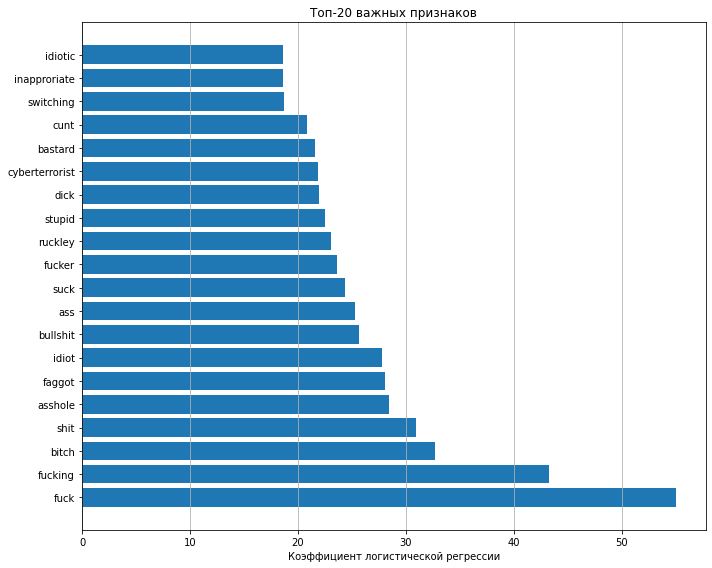

In [33]:
top_features = [names[i] for i in imp_ids]
top_coefs = coef[imp_ids]

plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefs)
plt.xlabel("Коэффициент логистической регрессии")
plt.title("Топ-20 важных признаков")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Выводы

1. Пропусков в данных нет. Удален лишний столбец.
2. Текст лемматизирован и очищен от лишнего.
3. Подобраны гиперпараметры для логистической регрессии: Лучшие параметры: {'model__C': 2.8, 'model__penalty': 'l1', 'model__solver': 'liblinear'}. *F1-score* = 0.75
4. Самое популярное слово - *fuck*.